In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm

In [ ]:
!pip install gstools
import gstools as gs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 10.3 MB/s eta 0:00:00


# Preliminaries

In this notebook we will work through the solution of inverse problems using machine learning techniques.
The goal is rather introductory, more complex networks and tweaking of code can lead to much better results that we present here. We aim to give an introduction with simple code that can be used and modified by potential students.

We assume to have a forward problem of the form
$$ A u + \epsilon = d $$
where $A$ is the forward operator, $u$ is the model, $\epsilon \sim N(0, \sigma^2 I)$ is the noise and $d$ is the observed data.
The goal is to recover $u$ from the noisy data $d$.

Throughout this tutorial we use simple yet powerful examples.
The first example is the borehole tomography where the each datum is
$$ d_i = \int_{{\rm ray}_i} u(x,z) d\ell  = \int_{\Omega} u(x,z)\, \delta(x-x(p_i),z-z(p_i)) dx\, dz$$
Here, $p_i$ is the ray path and $\delta$ is the Dirac delta function.

Below we generate the matrix $A$ for a collection of rays set on a mesh discretized by the vectors $x$ and $z$.





In [ ]:
# Codes for the forward tomography problem
class tomography(nn.Module):

    def __init__(self, zs, ze, x, z):
      # rays start at (x[0], zs[i]) and end at (x[-1], ze[j])

        super().__init__()

        self.zs = zs
        self.ze = ze
        self.z  = z
        self.x  = x
        self.A = self.get_tomo_matrix(zs, ze, x, z)


    def get_ray(self, zs, ze, x, z):

        n = x.numel()
        X, Z = torch.meshgrid(x, z)


        s = (ze-zs)/(x[-1]-x[0])
        p = s*x + zs

        # Approximate the delta function over the path
        sigma = (x[1]-x[0])*2
        ray = torch.exp(-(X-x.unsqueeze(1))**2/sigma -(Z-p.unsqueeze(1))**2/sigma)
        ray[ray<0.1] = 0
        return ray

    def get_tomo_matrix(self, zs, ze, x, z):

        n = zs.numel()

        A = torch.zeros(0, x.numel()*z.numel())
        A = A.to_sparse()
        nrays = tqdm.trange(n)

        for i in nrays:
            ray = self.get_ray(zs[i], ze[i], x, z)
            ray = ray.reshape(1, -1)
            ray = ray.to_sparse()
            A = torch.cat((A,ray),dim=0)
            nrays.set_description('Percent computed: {:2f}'.format(100*i/n))

        return A

    def forward(self, u):
      return self.A@u.flatten()

    def adjoint(self, b):
      return self.A.t()@b.flatten()


In [ ]:
# Generate a forward problem
# Generte the forward matrix
x = torch.linspace(0, 63, 64)
z = torch.linspace(0, 127, 128)

t = torch.linspace(0, 127, 65)
zs, ze = torch.meshgrid(t, t)
zs = zs.flatten()
ze = ze.flatten()

tomo = tomography(zs, ze, x, z)
print(' ')
print(' ')

print('Forward problem dim = ', tomo.A.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Percent computed: 99.976331: 100%|██████████| 4225/4225 [01:26<00:00, 49.11it/s]


 
 
Forward problem dim =  torch.Size([4225, 8192])


Text(0.5, 1.0, 'A single ray')

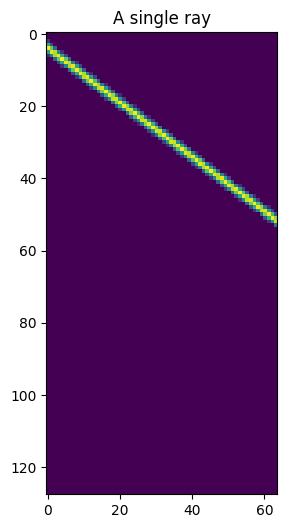

In [ ]:
ray = tomo.get_ray(tomo.zs[156], tomo.ze[156], tomo.x, tomo.z)
plt.figure(1, figsize=[6,6])
plt.clf()
plt.imshow(ray.t())
plt.title('A single ray')

Text(0.5, 1.0, 'Ray Coverage')

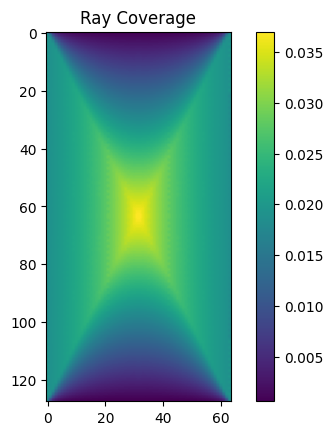

In [ ]:
a = torch.mean(tomo.A.to_dense(), dim=0)
a = a.to_dense()
a = a.reshape(64, 128)
plt.imshow(a.t())
plt.colorbar()
plt.title('Ray Coverage')

Text(0.5, 1.0, 'The forward modeling matrix')

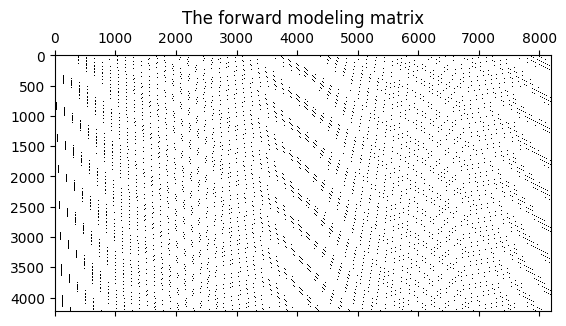

In [ ]:
B = tomo.A.to_dense().numpy()
plt.spy(B)
plt.title('The forward modeling matrix')

In [ ]:
#UU, SS, VV = torch.svd(torch.tensor(B))
#plt.semilogy(torch.diag(SS))

**The Model Space**

When considering an inversion we need to think about potential models (more later). Let us start with a simple, non-realistic model.


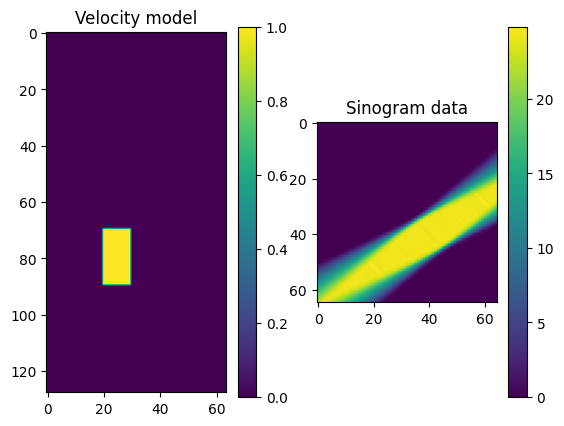

In [ ]:
u = torch.zeros(64, 128)
u[20:30, 70:90] = 1.0

data = tomo(u)
plt.subplot(1, 2, 1)
plt.imshow(u.t())
plt.colorbar()
plt.title('Velocity model')
plt.subplot(1, 2, 2)
plt.imshow(data.reshape(65, 65))
plt.title('Sinogram data')
plt.colorbar()


Rather than using a very simplistic model space it is better to use some realistic one. Here we use models that are generated from a geostatistical package.

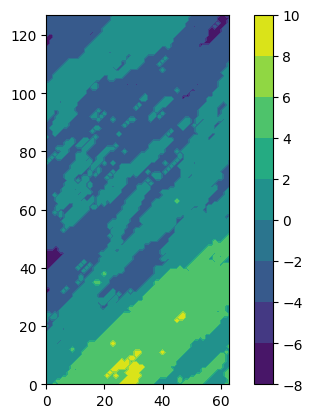

In [ ]:
x = np.arange(64)
z = np.arange(128)

#model = gs.Gaussian(dim=2, var=0.4, len_scale=[9, 5], anis=0.9, angles=np.pi/8)
model = gs.Exponential(dim=2, var=9, len_scale=[90, 25], angles=np.pi/4)
srf = gs.SRF(model, mean=0)

srf.structured([x,z])
# Transform
values1 = np.linspace(np.min(srf.field), np.max(srf.field), 5)
u = srf.transform("discrete", store="f1", values=values1)
#u = srf.transform("zinnharvey", conn="high")
plt.contourf(x, z, u.transpose())
plt.axis('image')
plt.colorbar()

u = torch.tensor(u, dtype=torch.float32)
utrue = u.clone()


We can now use the forward model and the simulated model to generate some data we can try to invert

Noise level =  0.08097624778747559


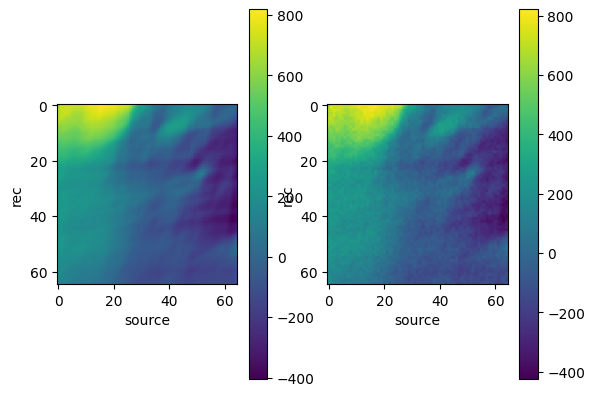

In [ ]:
d = tomo(u)
plt.subplot(1,2,1)
plt.imshow(d.reshape(65,65))
plt.xlabel('source')
plt.ylabel('rec')
plt.colorbar()

# Add noise to the data
noise = torch.randn_like(d)
sig   = 20
dn = d + sig*noise
plt.subplot(1,2,2)
plt.imshow(dn.reshape(65, 65))
plt.xlabel('source')
plt.ylabel('rec')

plt.colorbar()

SNR = (dn-d).norm()/dn.norm()
print('Noise level = ', (SNR).item())

In [ ]:
def steepest_descent(forProb, data, niter):

  r = data.clone()
  g = forProb.adjoint(r)
  u = 0
  for i in range(niter):

    Ag = forProb(g)
    mu = (Ag*r).mean()/(Ag*Ag).mean()
    u  = u + mu*g
    r  = r - mu*Ag
    g  = forProb.adjoint(r)
    print('%3d       %3.2e'%(i, r.norm()/data.norm()))
  return u

In [ ]:
uhat = steepest_descent(tomo, dn, 20)

  0       4.08e-01
  1       2.79e-01
  2       2.22e-01
  3       1.88e-01
  4       1.66e-01
  5       1.50e-01
  6       1.38e-01
  7       1.29e-01
  8       1.21e-01
  9       1.15e-01
 10       1.11e-01
 11       1.07e-01
 12       1.03e-01
 13       1.00e-01
 14       9.77e-02
 15       9.56e-02
 16       9.37e-02
 17       9.20e-02
 18       9.06e-02
 19       8.93e-02


Recovery Error =  tensor(0.5303)


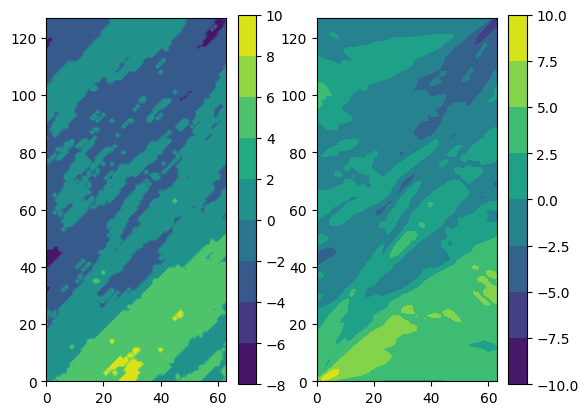

In [ ]:
plt.subplot(1,2,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uhat.view(-1)-u.view(-1)).norm()/(u.view(-1)).norm())


In [ ]:
def momentum_steepest_descent(forProb, data, niter, lr=0.1, momentum=0.8):
    r = data.clone()
    g = forProb.adjoint(r)
    u = 0
    v = 0  # Momentum term initialization

    for i in range(niter):
        Ag = forProb(g)
        mu = (Ag * r).mean() / (Ag * Ag).mean()

        # Update with momentum and learning rate
        v = momentum * v + lr * mu * g
        u = u + v

        r = r - mu * Ag
        g = forProb.adjoint(r)

        print(f'{i:3d}       {r.norm() / data.norm():3.2e}')

    return u
    return u

In [ ]:
uhat1 = momentum_steepest_descent(tomo, dn, 30)

  0       4.08e-01
  1       2.79e-01
  2       2.22e-01
  3       1.88e-01
  4       1.66e-01
  5       1.50e-01
  6       1.38e-01
  7       1.29e-01
  8       1.21e-01
  9       1.15e-01
 10       1.11e-01
 11       1.07e-01
 12       1.03e-01
 13       1.00e-01
 14       9.77e-02
 15       9.56e-02
 16       9.37e-02
 17       9.20e-02
 18       9.06e-02
 19       8.93e-02
 20       8.81e-02
 21       8.70e-02
 22       8.60e-02
 23       8.52e-02
 24       8.44e-02
 25       8.36e-02
 26       8.29e-02
 27       8.23e-02
 28       8.17e-02
 29       8.12e-02


Recovery Error =  tensor(0.5303)


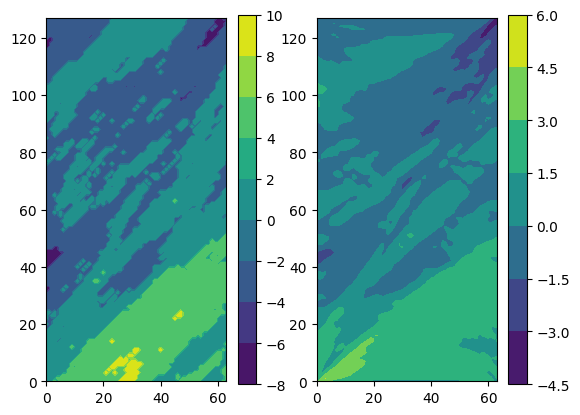

In [ ]:
plt.subplot(1,2,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(x, z, uhat1.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uhat.view(-1)-u.view(-1)).norm()/(u.view(-1)).norm())

In [ ]:
def momentum_steepest_descent_with_adaptive_lr_and_regularization(forProb, data, niter, lr=1e-4, lr_decay=0.99, momentum=0.9, regularization_lambda=1e-4):
    r = data.clone()
    g = forProb.adjoint(r)
    u = 0
    v = 0  # Momentum term initialization

    for i in range(niter):
        Ag = forProb(g)
        mu = (Ag * r).mean() / (Ag * Ag).mean()

        # Update with momentum, learning rate, and regularization
        v = momentum * v + lr * mu * g - lr * regularization_lambda * u
        u = u + v

        r = r - mu * Ag
        g = forProb.adjoint(r)

        # Update learning rate with decay
        lr *= lr_decay

        print(f'{i:3d}       {r.norm() / data.norm():3.2e}')

    return u


In [ ]:
uhat2 = momentum_steepest_descent_with_adaptive_lr_and_regularization(tomo, dn, 30)

  0       4.08e-01
  1       2.79e-01
  2       2.22e-01
  3       1.88e-01
  4       1.66e-01
  5       1.50e-01
  6       1.38e-01
  7       1.29e-01
  8       1.21e-01
  9       1.15e-01
 10       1.11e-01
 11       1.07e-01
 12       1.03e-01
 13       1.00e-01
 14       9.77e-02
 15       9.56e-02
 16       9.37e-02
 17       9.20e-02
 18       9.06e-02
 19       8.93e-02
 20       8.81e-02
 21       8.70e-02
 22       8.60e-02
 23       8.52e-02
 24       8.44e-02
 25       8.36e-02
 26       8.29e-02
 27       8.23e-02
 28       8.17e-02
 29       8.12e-02


In [ ]:
def momentum_steepest_descent_with_l1(forProb, data, niter, lr=0.01, momentum=0.9, regularization_lambda=0.1):
    r = data.clone()
    g = forProb.adjoint(r)
    u = 0
    v = 0  # Momentum term initialization

    for i in range(niter):
        Ag = forProb(g)
        mu = (Ag * r).mean() / (Ag * Ag).mean()

        # Update with momentum and learning rate
        v = momentum * v + lr * mu * g
        u = u + v

        # Apply L1 regularization
        u = np.sign(u) * np.maximum(np.abs(u) - lr * regularization_lambda, 0)

        r = r - mu * Ag
        g = forProb.adjoint(r)

        print(f'{i:3d}       {r.norm() / data.norm():3.2e}')

    return u


In [ ]:
uhat3 = momentum_steepest_descent_with_l1(tomo, dn, 30)

  0       4.08e-01
  1       2.79e-01
  2       2.22e-01
  3       1.88e-01
  4       1.66e-01
  5       1.50e-01
  6       1.38e-01
  7       1.29e-01
  8       1.21e-01
  9       1.15e-01
 10       1.11e-01
 11       1.07e-01
 12       1.03e-01
 13       1.00e-01
 14       9.77e-02
 15       9.56e-02
 16       9.37e-02
 17       9.20e-02
 18       9.06e-02
 19       8.93e-02
 20       8.81e-02
 21       8.70e-02
 22       8.60e-02
 23       8.52e-02
 24       8.44e-02
 25       8.36e-02
 26       8.29e-02
 27       8.23e-02
 28       8.17e-02
 29       8.12e-02


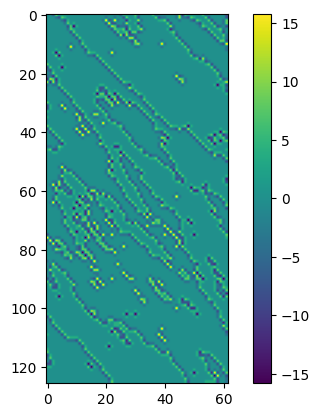

In [ ]:
W = torch.tensor([[0,-1,0],[-1, 4, -1], [0, -1.0, 0]])
W  = W.reshape(1,1,3,3)
U2d = u.reshape(64, 128).t().unsqueeze(0).unsqueeze(0)
Q = F.conv2d(U2d, W)
plt.imshow(Q.squeeze())
plt.colorbar()


In [ ]:
# Codes for the forward tomography problem
class regularization(nn.Module):

    def __init__(self, nx, nz):

        super().__init__()

        self.nx = nx
        self.nz = nz
        W = torch.tensor([[-2,-1,-2],[-1, 12, -1], [-2, -1.0, -2]])
        self.W  = W.reshape(1,1,3,3)


    def forward(self, u):


      u = u.reshape(1,1,self.nx,self.nz)
      Wu = F.conv2d(u, self.W)
      WTWu = F.conv_transpose2d(Wu, self.W)
      return 0.5*(Wu).norm()**2, WTWu


#Reg = regularization(64, 128)

#u = torch.randn(64*128)
#out, Hw = Reg(u)

#print(out, Hw.shape)





In [ ]:
def conjugate_gradient(forProb, reg, alpha, d, niter=10, tol=1e-3):

  def HmatVec(x, forProb, reg, alpha):
    Ax = forProb(x)
    ATAx = forProb.adjoint(Ax)
    _, WTWx = reg(x)
    Hx = ATAx + alpha*(WTWx).view(-1)
    return Hx

  rhs = forProb.adjoint(d)
  u   = 0
  r   = rhs.clone()

  p   = r.clone()
  for i in range(niter):
    Hp = HmatVec(p, forProb, reg, alpha)
    rsq = (r*r).mean()
    mu = (r*r).mean()/(p*Hp).mean()
    u = u + mu*p
    r = r - mu*Hp

    if r.norm()/rhs.norm() < tol:
      return u

    beta = (r*r).mean()/rsq
    p    = r + beta*p
    misfit = (forProb(u) - d).norm()/d.norm()
    print('%3d      %3.2e      %3.2e'%(i, r.norm()/rhs.norm(), misfit))
  return u

In [ ]:
reg = regularization(64, 128)
uReg = conjugate_gradient(tomo, reg, 1e3, dn, niter=100, tol=1e-5)

  0      3.55e-01      4.08e-01
  1      6.85e-01      3.77e-01
  2      7.53e-01      3.05e-01
  3      5.26e-01      2.61e-01
  4      3.51e-01      2.50e-01
  5      2.97e-01      2.39e-01
  6      3.03e-01      2.25e-01
  7      2.92e-01      2.08e-01
  8      2.57e-01      1.94e-01
  9      2.00e-01      1.88e-01
 10      1.59e-01      1.84e-01
 11      1.46e-01      1.80e-01
 12      1.59e-01      1.75e-01
 13      1.74e-01      1.68e-01
 14      1.88e-01      1.58e-01
 15      1.72e-01      1.51e-01
 16      1.37e-01      1.46e-01
 17      1.07e-01      1.44e-01
 18      8.54e-02      1.43e-01
 19      7.94e-02      1.41e-01
 20      8.26e-02      1.39e-01
 21      9.55e-02      1.37e-01
 22      1.08e-01      1.34e-01
 23      1.10e-01      1.30e-01
 24      1.01e-01      1.28e-01
 25      8.30e-02      1.27e-01
 26      6.83e-02      1.26e-01
 27      5.88e-02      1.26e-01
 28      5.60e-02      1.25e-01
 29      5.84e-02      1.24e-01
 30      6.48e-02      1.23e-01
 31     

In [ ]:
import torch

def conjugate_gradient_improved(forProb, reg, alpha, d, niter=10, tol=1e-3, absolute_tol=1e-5):
    def HmatVec(x, forProb, reg, alpha):
        Ax = forProb(x)
        ATAx = forProb.adjoint(Ax)
        _, WTWx = reg(x)
        Hx = ATAx + alpha * WTWx.view(-1)
        return Hx

    rhs = forProb.adjoint(d)
    u = torch.zeros_like(rhs)  # Ensure u is initialized to match the shape of rhs

    r = rhs.clone()
    p = r.clone()
    rsq_old = (r * r).mean()

    for i in range(niter):
        Hp = HmatVec(p, forProb, reg, alpha)
        rsq = (r * r).mean()
        pHp = (p * Hp).mean()

        if pHp.abs() < 1e-8:
            print("Warning: Small p * Hp encountered, stopping iteration.")
            break

        mu = rsq / pHp
        u_new = u + mu * p
        r_new = r - mu * Hp

        # Relative and Absolute Convergence Checks
        if (u_new - u).norm() / (u.norm() + 1e-8) < tol or r_new.norm() < absolute_tol:
            print(f'Iteration {i}: Converged with relative change {((u_new - u).norm() / (u.norm() + 1e-8)):.2e}, residual norm {r_new.norm():.2e}')
            return u_new

        u = u_new
        r = r_new

        rsq_new = (r * r).mean()
        beta = rsq_new / rsq_old
        p = r + beta * p
        rsq_old = rsq_new

        misfit = (forProb(u) - d).norm() / d.norm()
        print(f'{i:3d}      {r.norm()/rhs.norm():.2e}      {misfit:.2e}')

    return u


In [ ]:
uReg1 = conjugate_gradient_improved(tomo, reg, 1e3, dn, niter=100, tol=1e-5)

  0      3.55e-01      4.08e-01
  1      6.85e-01      3.77e-01
  2      7.53e-01      3.05e-01
  3      5.26e-01      2.61e-01
  4      3.51e-01      2.50e-01
  5      2.97e-01      2.39e-01
  6      3.03e-01      2.25e-01
  7      2.92e-01      2.08e-01
  8      2.57e-01      1.94e-01
  9      2.00e-01      1.88e-01
 10      1.59e-01      1.84e-01
 11      1.46e-01      1.80e-01
 12      1.59e-01      1.75e-01
 13      1.74e-01      1.68e-01
 14      1.88e-01      1.58e-01
 15      1.72e-01      1.51e-01
 16      1.37e-01      1.46e-01
 17      1.07e-01      1.44e-01
 18      8.54e-02      1.43e-01
 19      7.94e-02      1.41e-01
 20      8.26e-02      1.39e-01
 21      9.55e-02      1.37e-01
 22      1.08e-01      1.34e-01
 23      1.10e-01      1.30e-01
 24      1.01e-01      1.28e-01
 25      8.30e-02      1.27e-01
 26      6.83e-02      1.26e-01
 27      5.88e-02      1.26e-01
 28      5.60e-02      1.25e-01
 29      5.84e-02      1.24e-01
 30      6.48e-02      1.23e-01
 31     

Recovery Error =  tensor(0.5318)
Recovery Error =  tensor(0.5303)
Recovery Error =  tensor(0.5318)


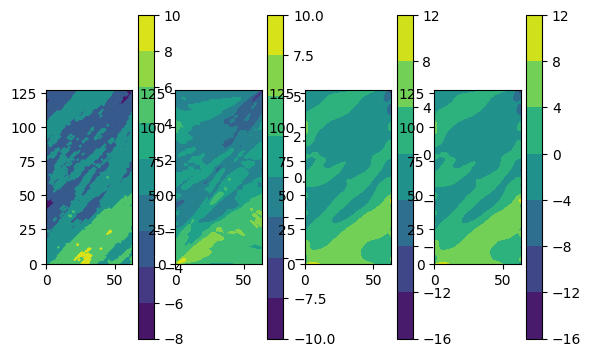

In [ ]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uReg1.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uReg1.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())


In [ ]:
class SL1regularization(nn.Module):

    def __init__(self, nx=64, nz=128, nhid=16):

        super().__init__()

        self.nx = nx
        self.nz = nz
        self.W = nn.Parameter(torch.rand(nhid, 1, 5, 5))
        #self.W = nn.Conv2d(1, nhid, kernel_size=5)


    def forward(self, u):

      u = u.reshape(1,1,self.nx,self.nz)
      Wu = F.conv2d(u, self.W) #
      phi = torch.log(torch.cosh(Wu))
      Wu  = torch.tanh(Wu)
      phi_u = F.conv_transpose2d(Wu, self.W)
      return phi.mean(), phi_u


In [ ]:
class inet(nn.Module):

    def __init__(self, reg, forProb, nx=64, nz=128, niter=8):

        super().__init__()

        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        phi, g_phi = self.reg(u)
        u = u - self.alpha*g_phi

      return u



In [ ]:
reg = SL1regularization(nhid=16)
net = inet(reg, tomo, niter=5)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))


uR = net(dn)

Number of parameters =  400


Recovery Error =  tensor(0.5318)
Recovery Error =  tensor(0.5303)
Recovery Error =  tensor(0.9983, grad_fn=<DivBackward0>)


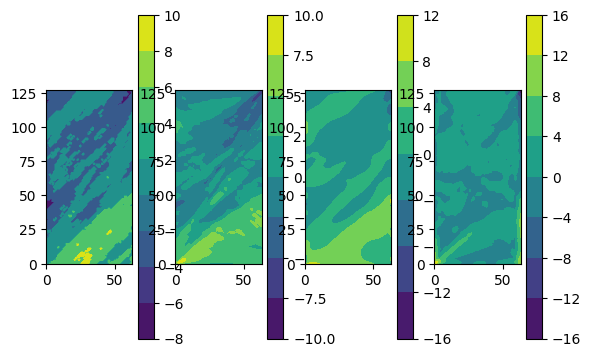

In [ ]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uR.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())



In [ ]:
# training the network
optim = Adam(net.parameters(), lr=1e-2)

n_epochs = 50

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()




  0    9.97e-01
  1    9.81e-01
  2    9.62e-01
  3    9.43e-01
  4    9.24e-01
  5    9.07e-01
  6    8.92e-01
  7    8.73e-01
  8    8.56e-01
  9    8.41e-01
 10    8.28e-01
 11    8.15e-01
 12    7.99e-01
 13    7.83e-01
 14    7.66e-01
 15    7.48e-01
 16    7.29e-01
 17    7.07e-01
 18    6.86e-01
 19    6.64e-01
 20    6.46e-01
 21    6.27e-01
 22    6.09e-01
 23    5.90e-01
 24    5.73e-01
 25    5.58e-01
 26    5.45e-01
 27    5.32e-01
 28    5.20e-01
 29    5.08e-01
 30    4.96e-01
 31    4.85e-01
 32    4.74e-01
 33    4.63e-01
 34    4.52e-01
 35    4.42e-01
 36    4.32e-01
 37    4.22e-01
 38    4.13e-01
 39    4.04e-01
 40    3.95e-01
 41    3.86e-01
 42    3.78e-01
 43    3.70e-01
 44    3.62e-01
 45    3.55e-01
 46    3.48e-01
 47    3.42e-01
 48    3.38e-01
 49    3.34e-01


Recovery Error =  tensor(0.5318)
Recovery Error =  tensor(0.5303)
Recovery Error =  tensor(0.5745, grad_fn=<DivBackward0>)


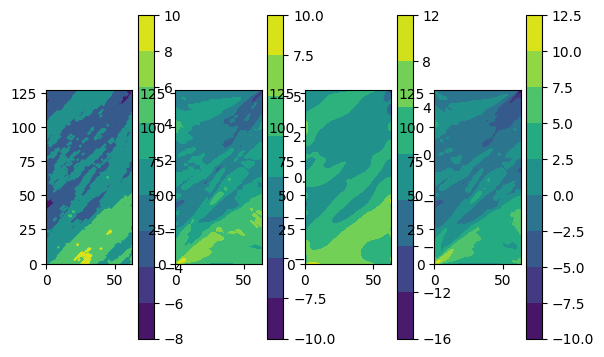

In [ ]:
uR = net(dn)
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uR.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())



In [ ]:
class inet_uroll(nn.Module):

    def __init__(self, forProb, nhid=16, nx=64, nz=128, niter=8):

        super().__init__()

        reg = nn.ParameterList()
        for i in range(niter):
          regi = SL1regularization(nhid=16)
          reg.append(regi)

        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        phi, g_phi = self.reg[i](u)
        u = u - self.alpha*g_phi

      return u



In [ ]:
net = inet_uroll(tomo, niter=5)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))


Number of parameters =  2000


In [ ]:
# training the network
optim = Adam(net.parameters(), lr=1e-2)

n_epochs = 50

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

  0    9.66e-01
  1    9.47e-01
  2    9.27e-01
  3    9.08e-01
  4    8.89e-01
  5    8.73e-01
  6    8.58e-01
  7    8.43e-01
  8    8.28e-01
  9    8.15e-01
 10    8.08e-01
 11    7.98e-01
 12    7.87e-01
 13    7.76e-01
 14    7.64e-01
 15    7.51e-01
 16    7.38e-01
 17    7.25e-01
 18    7.13e-01
 19    7.00e-01
 20    6.87e-01
 21    6.74e-01
 22    6.61e-01
 23    6.48e-01
 24    6.35e-01
 25    6.23e-01
 26    6.10e-01
 27    5.97e-01
 28    5.84e-01
 29    5.70e-01
 30    5.57e-01
 31    5.44e-01
 32    5.31e-01
 33    5.18e-01
 34    5.06e-01
 35    4.94e-01
 36    4.83e-01
 37    4.72e-01
 38    4.61e-01
 39    4.51e-01
 40    4.40e-01
 41    4.30e-01
 42    4.21e-01
 43    4.13e-01
 44    4.06e-01
 45    3.99e-01
 46    3.92e-01
 47    3.86e-01
 48    3.80e-01
 49    3.74e-01


In [ ]:
class resnet(nn.Module):

    def __init__(self, nhid=64, nlayers=3):

        super().__init__()


        self.nhid    = nhid
        self.nlayers = nlayers
        self.Kopen   = nn.Conv2d(1, nhid, kernel_size=1)
        self.K1       = nn.Parameter(1e-3*torch.randn(nlayers, nhid, nhid, 3, 3))
        self.K2       = nn.Parameter(1e-3*torch.randn(nlayers, nhid, nhid, 3, 3))
        self.Kclose   = nn.Conv2d(nhid, 1, kernel_size=1)


    def forward(self, u):

      u = self.Kopen(u)
      for i in range(self.nlayers):
        du = F.conv2d(u, self.K1[i], padding=1)
        du = F.leaky_relu(du, negative_slope=0.2)
        du = F.conv2d(du, self.K2[i], padding=1)

        u = u + du

      u = self.Kclose(u)

      return u

In [ ]:
net = resnet()
uout = net(u.reshape(1, 1, 64, 128))

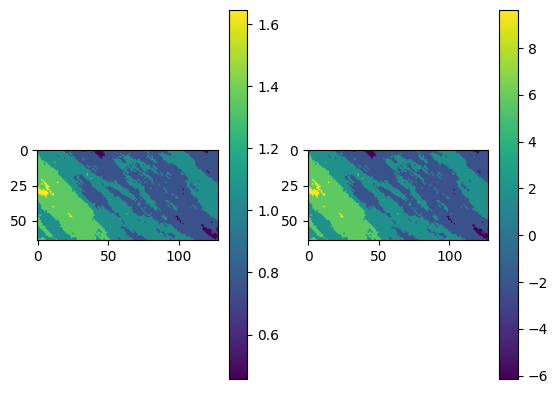

In [ ]:
plt.subplot(1,2,1)
plt.imshow(uout[0,0,:,:].detach().cpu())
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(u[:,:].detach().cpu())
plt.colorbar()

In [ ]:
class inet_res(nn.Module):

    def __init__(self, forProb, nhid=64, nx=64, nz=128, niter=8):

        super().__init__()

        reg = nn.ParameterList()
        for i in range(niter):
          regi = resnet(nhid=nhid)
          reg.append(regi)
        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        s = self.reg[i](u)
        u = u - self.alpha*s

      return u



In [ ]:
# training the network
net = inet_res(tomo)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))

optim = Adam(net.parameters(), lr=1e-4)

n_epochs = 150

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

Number of parameters =  1771016
  0    2.92e-01
  1    2.92e-01
  2    2.91e-01
  3    2.91e-01
  4    2.91e-01
  5    2.91e-01
  6    2.90e-01
  7    2.90e-01
  8    2.89e-01
  9    2.89e-01
 10    2.88e-01
 11    2.86e-01
 12    2.84e-01
 13    2.82e-01
 14    2.80e-01
 15    2.78e-01
 16    2.77e-01
 17    2.77e-01
 18    2.76e-01
 19    2.75e-01
 20    2.73e-01
 21    2.71e-01
 22    2.68e-01
 23    2.65e-01
 24    2.63e-01
 25    2.61e-01
 26    2.60e-01
 27    2.59e-01
 28    2.56e-01
 29    2.53e-01
 30    2.50e-01
 31    2.47e-01
 32    2.44e-01
 33    2.42e-01
 34    2.42e-01
 35    2.41e-01
 36    2.37e-01
 37    2.36e-01
 38    2.37e-01
 39    2.34e-01
 40    2.33e-01
 41    2.32e-01
 42    2.31e-01
 43    2.28e-01
 44    2.27e-01
 45    2.26e-01
 46    2.24e-01
 47    2.23e-01
 48    2.22e-01
 49    2.20e-01
 50    2.19e-01
 51    2.18e-01
 52    2.17e-01
 53    2.15e-01
 54    2.14e-01
 55    2.13e-01
 56    2.12e-01
 57    2.11e-01
 58    2.10e-01
 59    2.09e-01
 60    2

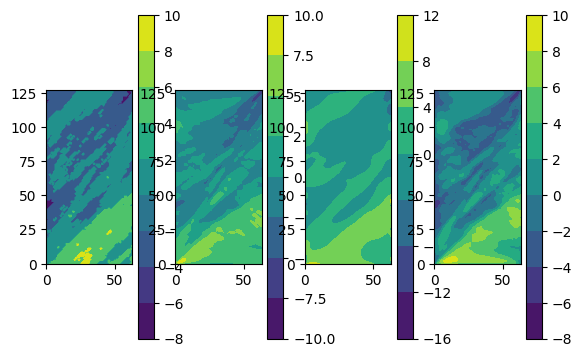

In [ ]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
